# Sentiment 
Code adapted from How to Make a Racist AI Without Even Knowing
http://blog.conceptnet.io/posts/2017/how-to-make-a-racist-ai-without-really-trying/

In [34]:
import numpy as np
import pandas as pd
import re
import statsmodels.formula.api

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /home/arnoldyb/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [9]:
# DO THIS ONLY ONCE
# Downloads and unpacks the GloVe embeddings 
!wget -c http://nlp.stanford.edu/data/glove.42B.300d.zip

--2019-07-16 04:26:26--  http://nlp.stanford.edu/data/glove.42B.300d.zip
UnZip 6.00 of 20 April 2009, by Debian. Original by Info-ZIP.

Usage: unzip [-Z] [-opts[modifiers]] file[.zip] [list] [-x xlist] [-d exdir]
  Default action is to extract files in list, except those in xlist, to exdir;
  file[.zip] may be a wildcard.  -Z => ZipInfo mode ("unzip -Z" for usage).

  -p  extract files to pipe, no messages     -l  list files (short format)
  -f  freshen existing files, create none    -t  test compressed archive data
  -u  update files, create if necessary      -z  display archive comment only
  -v  list verbosely/show version info       -T  timestamp archive to latest
  -x  exclude files that follow (in xlist)   -d  extract files into exdir
modifiers:
  -n  never overwrite existing files         -q  quiet mode (-qq => quieter)
  -o  overwrite files WITHOUT prompting      -a  auto-convert any text files
  -j  junk paths (do not make directories)   -aa treat ALL files as text
  -U  use e

In [10]:
# unzip the file
# if you don't have unzip installed, run: !sudo apt-get install unzip
!mkdir -p data/sent/
!unzip glove.42B.300d.zip -d data/sent/

Archive:  glove.42B.300d.zip
  inflating: glove.42B.300d.txt      


In [12]:
def load_embeddings(filename):
    """
    Load a DataFrame from pretrained embeddings. 
    For this, we are going to use GloVe.
    """
    labels = []
    rows = []
    with open(filename, encoding='utf-8') as infile:
        for i, line in enumerate(infile):
            items = line.rstrip().split(' ')
            if len(items) == 2:
                # This is a header row giving the shape of the matrix
                continue
            labels.append(items[0])
            values = np.array([float(x) for x in items[1:]], 'f')
            rows.append(values)
    
    return pd.DataFrame(np.vstack(rows), index=labels, dtype='f')

embeddings = load_embeddings('glove.42B.300d.txt')
embeddings.shape

(1917494, 300)

In [ ]:
!wget http://www.cs.uic.edu/~liub/FBS/opinion-lexicon-Engli
sh.rar

In [ ]:
# if you don't have unrar installed, run commented out line
#!sudo apt-get install unrar
!unrar x opinion-lexicon-English.rar -d data/sent/

In [22]:
def load_lexicon(filename):
    """
    Load a file from Bing Liu's sentiment lexicon
    (https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html), containing
    English words in Latin-1 encoding.
    
    One file contains a list of positive words, and the other contains
    a list of negative words. The files contain comment lines starting
    with ';' and blank lines, which should be skipped.
    """
    lexicon = []
    with open(filename, encoding='latin-1') as infile:
        for line in infile:
            line = line.rstrip()
            if line and not line.startswith(';'):
                lexicon.append(line)
    return lexicon

pos_words = load_lexicon('data/sent/opinion-lexicon-English/positive-words.txt')
neg_words = load_lexicon('data/sent/opinion-lexicon-English/negative-words.txt')

In [23]:
pos_vectors = embeddings.loc[pos_words].dropna()
neg_vectors = embeddings.loc[neg_words].dropna()

/home/arnoldyb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/home/arnoldyb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


In [24]:
vectors = pd.concat([pos_vectors, neg_vectors])
targets = np.array([1 for entry in pos_vectors.index] + [-1 for entry in neg_vectors.index])
labels = list(pos_vectors.index) + list(neg_vectors.index)

In [25]:
train_vectors, test_vectors, train_targets, test_targets, train_labels, test_labels = \
    train_test_split(vectors, targets, labels, test_size=0.1, random_state=0)

In [26]:
model = SGDClassifier(loss='log', random_state=0, n_iter=100)
model.fit(train_vectors, train_targets)

/home/arnoldyb/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=100,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=0, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [27]:
accuracy_score(model.predict(test_vectors), test_targets)

0.9502262443438914

In [89]:
def vecs_to_sentiment(vecs):
    # predict_log_proba gives the log probability for each class
    predictions = model.predict_log_proba(vecs)
    # To see an overall positive vs. negative classification in one number,
    # we take the log probability of positive sentiment minus the log
    # probability of negative sentiment.
    return predictions[:, 1] - predictions[:, 0]


def words_to_sentiment(words):
    vecs = embeddings.loc[words].dropna()
    log_odds = vecs_to_sentiment(vecs)
    return pd.DataFrame({'sentiment': log_odds}, index=vecs.index)

# Show 20 examples from the test set
words_to_sentiment(test_labels).ix[:20]

/home/arnoldyb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  app.launch_new_instance()


,sentiment
fidget,-9.931679
interrupt,-9.634706
staunchly,1.466919
imaginary,-2.989215
taxing,0.468522
world-famous,6.908561
low-cost,9.237223
disapointment,-8.737182
totalitarian,-10.851580
bellicose,-8.328674


In [107]:
def text_to_sentiment(text):
    tokens = word_tokenize(text.lower())
    try: 
        sentiments = words_to_sentiment(tokens)
    except: # handle case where there's no known words in input
        return 0
    return sentiments['sentiment'].mean()

In [108]:
text_to_sentiment("except you all")

4.413513239329204

In [118]:
import os
import csv
from NYT_parser import NYTArticle
from utilities import *

article = NYTArticle.from_file('../data/1995/01/25/0739212.xml')


In [119]:
article.title

"The President's Address: 'We Heard America Shouting'"

In [120]:
text_to_sentiment(article.title)

/home/arnoldyb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  # This is added back by InteractiveShellApp.init_path()


-0.6524500120904618

In [121]:
article.paragraphs

["Following is President Clinton's State of the Union Message last night, as recorded by The New York Times:",
 'Mr. President, Mr. Speaker, members of the 104th Congress, my fellow Americans, again we are here in the sanctuary of democracy. And once again, our democracy has spoken.',
 'So let me begin by congratulating all of you here in the 104th Congress, and congratulating you, Mr. Speaker.',
 'If we agree on nothing else tonight, we must agree that the American people certainly voted for change in 1992 and in 1994.',
 'And as I look out at you, I know how some of you must have felt in 1992.',
 "I must say that in both years we didn't hear America singing, we heard America shouting. And now all of us, Republicans and Democrats alike, must say: We hear you. We will work together to earn the jobs you have given us. For we are the keepers of the sacred trust and we must be faithful to it in this new and very demanding era.",
 'Over 200 years ago, our founders changed the entire course

In [129]:
def score_article(text):
    score = 0
    num_sentences = 0
    for sentence in text:
        num_sentences += 1
        score += text_to_sentiment(sentence)
    if num_sentences == 0:
        return 0
    else:
        return score / num_sentences

In [124]:
print("The score of this article is", score_article(article.paragraphs))

/home/arnoldyb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  # This is added back by InteractiveShellApp.init_path()


The score of this article is 2.006863742217433


In [157]:
import warnings
warnings.filterwarnings('ignore')

headline_sent = list()
body_sent = list()

# go through a few examples
start_article = 1212948
end_article = 1213168 # last possible is 1213168

for article_num in range(start_article,end_article):
    article = NYTArticle.from_file('../data/2000/07/07/'+str(article_num)+'.xml')
    print("File ID",article.docid)
    print("Headline:",article.title)
    headline_sent.append(text_to_sentiment(article.title))
    body_sent.append(score_article(article.paragraphs))
    print("Headline sentiment",headline_sent[-1])
    print("Body sentiment",body_sent[-1])
    print("=====================================")
    
scoreDF = pd.DataFrame({'Head_Sent': headline_sent, 'Body_Sent': body_sent})

File ID 1212948
Headline: EATING OUT
Headline sentiment -3.0013142895674703
Body sentiment 0.39008107313344503
File ID 1212949
Headline: DINER'S JOURNAL
Headline sentiment 2.718007229918508
Body sentiment 1.017822998944401
File ID 1212950
Headline: MOVIE GUIDE
Headline sentiment 3.442711310399978
Body sentiment 1.291338175962473
File ID 1212951
Headline: ART GUIDE
Headline sentiment 5.753142908201992
Body sentiment 1.1338177190999228
File ID 1212952
Headline: Street of Automotive Dreams
Headline sentiment 1.4676077393304319
Body sentiment 1.0385391159751043
File ID 1212953
Headline: As a Ribbon Unfurls Into Infinity
Headline sentiment 1.7544117015317513
Body sentiment 1.2050679864163008
File ID 1212954
Headline: SPARE TIMES: FOR CHILDREN
Headline sentiment 2.6320195260561525
Body sentiment 1.3906725185128606
File ID 1212955
Headline: A Flame in the Ashes of Postwar Berlin
Headline sentiment 0.6318879027783384
Body sentiment 0.7856963934418579
File ID 1212956
Headline: In a John Brown P

Headline sentiment 1.9808792286939632
Body sentiment 1.5532151786609274
File ID 1212998
Headline: Residential Real Estate; Bill Puts Wrinkle in 'Caveat Emptor'
Headline sentiment -0.01673891950924473
Body sentiment 0.5716716946669902
File ID 1212999
Headline: Key Rates
Headline sentiment 2.449906050026906
Body sentiment -0.81663107503581
File ID 1213000
Headline: John Oliver, 86, Ex-Newspaper Executive
Headline sentiment 0.8118756518015792
Body sentiment 0.9216955441193028
File ID 1213001
Headline: SBC's Long-Distance Rates For Texas Will Be Set Today
Headline sentiment 2.6012918230668167
Body sentiment 2.0199192148856517
File ID 1213002
Headline: Jubilant Protestant Stone-Throwers in Belfast
Headline sentiment 0.2658473702256854
Body sentiment 0
File ID 1213003
Headline: 'Big Brother' Proves Another Big Hit for CBS
Headline sentiment 1.129822458392022
Body sentiment 1.264503903366992
File ID 1213004
Headline: Gillette goes to the extreme with ads featuring Tom Green.
Headline sentimen

Headline sentiment 2.901740760143244
Body sentiment 1.0017742071918818
File ID 1213044
Headline: BUSINESS DIGEST
Headline sentiment 4.892173080364566
Body sentiment 1.2080243625532339
File ID 1213045
Headline: 2 Views of Mideast Peace
Headline sentiment 2.420038263635844
Body sentiment 1.112986622896423
File ID 1213046
Headline: Starr's Ex-Spokesman Charged With Contempt in Case on Leaks
Headline sentiment -0.83053910493472
Body sentiment 0.2786111410142254
File ID 1213047
Headline: To Save Russian Lives, Putin Wants Chechens to Enforce Law
Headline sentiment 1.1002869935536466
Body sentiment 0.2893069104104202
File ID 1213048
Headline: Italy Looks at Plans to Free Inmates From Bursting Prisons
Headline sentiment 0.017670871706629575
Body sentiment 0.5122592032606609
File ID 1213049
Headline: Man Is Fatally Stabbed in a Parking Dispute
Headline sentiment -3.8070201335948695
Body sentiment 0.2853391295744823
File ID 1213050
Headline: Woman Sentenced for Killing Elderly Husband With Drug

Headline sentiment 1.0627560433855783
Body sentiment 0.5694751627351458
File ID 1213089
Headline: Interpublic Agencies Appoint Executives
Headline sentiment 1.5153458259817811
Body sentiment 2.2067965546975263
File ID 1213090
Headline: People
Headline sentiment 0.5403457297257979
Body sentiment 2.010718500915356
File ID 1213091
Headline: In Teeming Courts, Finding Strength in Family Ties
Headline sentiment 1.929402818254601
Body sentiment 0.45300132247967023
File ID 1213092
Headline: COMPANY BRIEFS
Headline sentiment 4.377927784523262
Body sentiment 0.9806596151659268
File ID 1213093
Headline: RUPIAH WEAK AGAINST DOLLAR
Headline sentiment -4.368628574131566
Body sentiment 1.8494462260850693
File ID 1213094
Headline: SOUTH KOREAN RATES UNCHANGED
Headline sentiment -0.867436499751532
Body sentiment 1.4504761605428371
File ID 1213095
Headline: EUROPEAN RATES UNCHANGED
Headline sentiment 2.0743890365713766
Body sentiment 1.5089779335784286
File ID 1213096
Headline: TWO ABANDON DUTCH WIRELE

Headline sentiment -2.3198787402528285
Body sentiment 3.284108668816986
File ID 1213140
Headline: Paid Notice: Deaths  FELDGARDEN, BENJAMIN
Headline sentiment -2.3641182634214437
Body sentiment 2.748147569273728
File ID 1213141
Headline: Paid Notice: Deaths  FORTUNOFF, ALAN
Headline sentiment -1.9595095850534332
Body sentiment 2.877389166428794
File ID 1213142
Headline: Paid Notice: Deaths  FOX, HERBERT O.
Headline sentiment -2.05985212457774
Body sentiment 2.90307079812995
File ID 1213143
Headline: Paid Notice: Deaths  GENOVESE, VIOLA T.
Headline sentiment -2.127594806492074
Body sentiment 1.1768424990948083
File ID 1213144
Headline: Paid Notice: Deaths  GINS, EVELYN FRIEDMAN
Headline sentiment -2.111417717547269
Body sentiment 2.560970048745603
File ID 1213145
Headline: Paid Notice: Deaths  GOLDBERG, SYLVIA HERZOG
Headline sentiment -1.5075110380885333
Body sentiment 1.7654089172206404
File ID 1213146
Headline: Paid Notice: Deaths  GUNDERSEN, HARRIET ADAMS
Headline sentiment -1.56346

In [158]:
scoreDF.describe()

,Head_Sent,Body_Sent
count,220.000000,220.000000
mean,0.389433,1.160341
std,2.308861,0.724338
min,-4.368629,-0.879009
25%,-1.436959,0.741343
50%,0.547120,1.132521
75%,2.001980,1.479346
max,6.720334,3.284109


(array([13., 24., 27., 33., 38., 38., 26., 13.,  4.,  4.]),
 array([-4.36862857, -3.25973228, -2.15083599, -1.0419397 ,  0.06695659,
         1.17585288,  2.28474917,  3.39364546,  4.50254175,  5.61143804,
         6.72033433]),
 <a list of 10 Patch objects>)

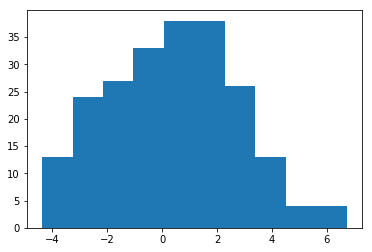

In [159]:
import matplotlib.pyplot as plt
plt.hist(scoreDF['Head_Sent'])

(array([ 3.,  1., 21., 34., 60., 59., 19.,  6., 11.,  6.]),
 array([-0.87900946, -0.46269764, -0.04638583,  0.36992598,  0.78623779,
         1.20254961,  1.61886142,  2.03517323,  2.45148504,  2.86779686,
         3.28410867]),
 <a list of 10 Patch objects>)

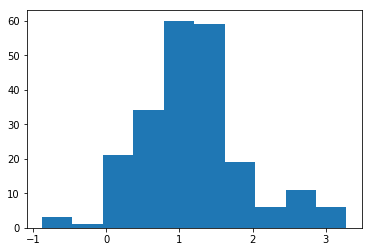

In [160]:
import matplotlib.pyplot as plt
plt.hist(scoreDF['Body_Sent'])

In [133]:
# the one negative headline + body text 
article_num = 1213027
article = NYTArticle.from_file('../data/2000/07/07/'+str(article_num)+'.xml')
print("Headline:",article.title)
print(article.paragraphs)


Headline: No Charges For Returning Rocker's Toss
['A Brooklyn man who was arrested after throwing a baseball back onto the Shea Stadium field after it was tossed into the stands by John Rocker will not be prosecuted, the Queens District Attorney said yesterday.', "The district attorney, Richard A. Brown, said the fan, Gregory Sweeney, 25, was not acting with criminal intent when he threw Rocker's toss back to the field during the Mets' 10-2 loss to the Atlanta Braves last Sunday. Brown noted that Rocker had safely returned to the Braves' bullpen by the time the ball landed on the field and suggested that Sweeney was simply goaded on by ''50,000 accomplices,'' chanting and urging him to throw the ball back. Sweeney had been charged with second-degree reckless endangerment.", "''A review of the available tapes and witness interviews indicate that no one was seriously placed at risk,'' Brown said. ''It would appear that Mr. Sweeney had no criminal intent and was doing nothing more than fo

## Some thoughts
After doing a quick and dirty EDA on the sentiment applied to one day's worth of articles, I'm a little worried. Most articles do not get scored overall negative. The one that did was actually a cute sort of article about a decision not to prosecute someone for throwing a baseball back onto a field (see cell above). 
Possible improvements:
* we could apply sentiment to just the lede
* we could set ranges for body text sentiment -- anything below the mean is "negative" even if most of the overall values are positive
* we could try a more nuanced sentiment classifier - one that has a range of emotions like happy, angry, etc. rather than positive/negative

